In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00


Mounted at /content/drive
(542379, 7)
         time_category_encoded  month  day  PULocationID  DOLocationID  \
1110493                      1      6    1            74            75   
1110494                      1      6    1            74            75   

         trip_distance  total_amount  
1110493           1.49           7.3  
1110494           1.43           6.8  
time_category_encoded   -0.125280
month                   -0.012773
day                      0.012356
PULocationID             0.172414
DOLocationID             0.078873
trip_distance            0.008135
total_amount             1.000000
Name: total_amount, dtype: float64
time_category_encoded    0
month                    0
day                      0
PULocationID             0
DOLocationID             0
trip_distance            0
total_amount             0
dtype: int64
(406784, 6)
(406784,)
(135595, 6)
(135595,)
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Train MAE: 3.9913
Train MSE: 39.7764
Train

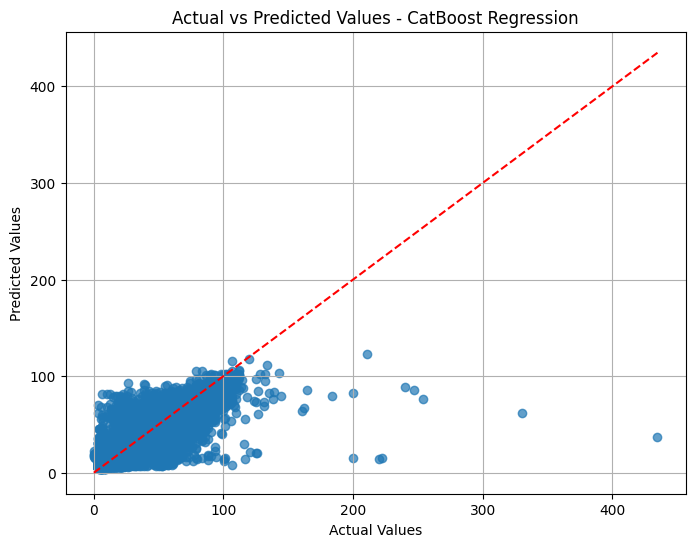

In [ ]:
import pandas as pd
import numpy as np
import catboost
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/NYC_DATA_SET/preprocessed_data_2020.csv')

# Filter the dataset for specific months
df_new = df[df['month'].isin([6, 7, 8, 9, 10, 11, 12])]

# Display the shape and first few rows
print(df_new.shape)
print(df_new.head(2))

# Check correlation with target variable
print(df_new.corr()['total_amount'])

# Check for missing values
print(df_new.isnull().sum())

# Define target and features
y = df_new['total_amount']
X = df_new.drop(columns=['total_amount'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(objective='RMSE', random_seed=42, verbose=0)

# Define hyperparameter grid
param_grid = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Grid Search
grid_search = GridSearchCV(estimator=catboost_model,
                           param_grid=param_grid,
                           cv=3,
                           scoring='neg_mean_squared_error',
                           verbose=1)

grid_search.fit(X_train, y_train)

# Best model & predictions
best_model = grid_search.best_estimator_

# Predict on train and test
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Compute metrics on test data
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# Also compute metrics on training data
mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print(f"Train MAE: {mae_train:.4f}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Train R²: {r2_train:.4f}\n")

print(f"Test MAE: {mae_test:.4f}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R²: {r2_test:.4f}")


# Evaluate Overfitting / Underfitting
print("\nTraining R2 Score:", r2_score(y_train, y_train_pred))
print("Testing R2 Score:", r2_score(y_test, y_test_pred))
print("Training MSE:", mean_squared_error(y_train, y_train_pred))
print("Testing MSE:", mean_squared_error(y_test, y_test_pred))

# Scatter Plot (Actual vs Predicted)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values - CatBoost Regression")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Ideal line
plt.grid(True)
plt.show()


In [ ]:
# Pickle
import joblib
joblib.dump(best_model, 'cat_model.pkl')
print("Saved tuned model: cat_model.pkl")

Saved tuned model: cat_model.pkl


In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Parameter grid for CatBoost
param_grid = {
    'iterations': [50, 100, 200],
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'l2_leaf_reg': [1, 3, 5]  # Equivalent to gamma in XGBoost
}

# Base model with early stopping and eval metric
catboost_model = CatBoostRegressor(
    random_seed=42,
    objective='RMSE',  # Set the objective
    verbose=0,  # Suppress output during training
)

# Grid SearchCV
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Best model
best_catboost_model_tuned_gs = grid_search.best_estimator_

# Fit best model with eval_set to collect learning curves
best_catboost_model_tuned_gs.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False  # Suppress output during training
)

# Predictions
y_pred_catboost_tuned_gs = best_catboost_model_tuned_gs.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred_catboost_tuned_gs)
mse = mean_squared_error(y_test, y_pred_catboost_tuned_gs)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_catboost_tuned_gs)

print("\nEvaluation of the best CatBoost model after tuning:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

# Plot Learning Curves (Train vs Test RMSE)
results = best_catboost_model_tuned_gs.get_evals_result()

train_rmse = results['learn']['RMSE']
test_rmse = results['validation']['RMSE']

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Train RMSE', color='blue')
plt.plot(test_rmse, label='Test RMSE', color='red')
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE Over Boosting Rounds - CatBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 324 candidates, totalling 972 fits


In [ ]:
# Save the best-tuned CatBoost model
joblib.dump(best_catboost_model_tuned_gs, 'best_catboost_model_tuned_gs.pkl')
print("Saved best-tuned model: best_catboost_model_tuned_gs.pkl")